# 센서 데이터로 움직임 분류하기
## 데이터 탐색

In [1]:
import numpy as np
import pandas as pd

In [2]:
feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt', sep = ' ', header = None, names = ['index','feature_name'], engine = 'python')
#피처 이름 파일 읽어오기
feature_name_df.head()

,index,feature_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [3]:
feature_name_df.shape

(561, 2)

In [4]:
#index 제거하고, feature_name만 리스트로 저장
feature_name = feature_name_df['feature_name'].tolist()
feature_name_tuple = tuple(feature_name) # 이름만 뽑아다가 튜플로 만듦
feature_name[:5] 

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y']

### [ X_train, X_test, Y_train, Y_test 데이터 파일도 분석에 사용할 수 있도록 준비]

In [6]:
unique_feature_name = []
# 데이터셋 중에 중복되는 이름이 있음 -> unique로 인덱스의 중복 제거

feature_count = {}
for name in feature_name: 
    if name in feature_count:
        feature_count[name] += 1
        unique_feature_name.append(f"{name}_{feature_count[name]}")
        # 바디자이로밴드1 이라는게 하나 있고 뒤에서 또나오면 
        # > 바디자이로밴드1_1 이라고 이름 붙이는 방식으로 함.
    else:
        feature_count[name] = 0
        unique_feature_name.append(name)
feature_name_tuple = unique_feature_name

X_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt', sep=r'\s+', names = feature_name_tuple, engine = 'python')
X_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt', sep=r'\s+', names = feature_name_tuple, engine = 'python')
Y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt', sep=r'\s+', header = None, names = ['action'], engine = 'python')
Y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt' , sep = r'\s+', header = None, names = ['action'], engine = 'python')

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
# 파일을 읽어서 저장하고 크기를 확인하면
# 훈련용 데이터는 7,352개, 테스트용 데이터는 2,947개로 구성된 것을 확인 가능

((7352, 561), (7352, 1), (2947, 561), (2947, 1))

In [ ]:
X_train.head()
# 훈련용 X 데이터는 feature_name에서 확인했던 561개 피처로 구성되어 있음

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [8]:
print(Y_train['action'].value_counts())
# Y 데이터는 6가지 움직임에 대한 레이블(분류할 class)값으로 되어있으므로, 
# 각 레이블의 데이터 개수value_counts( )를 확인

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


### [레이블 이름 파일을 로드하여 객체로 저장]

In [9]:
label_name_df = pd.read_csv('./data/UCI_HAR_Dataset/activity_labels.txt', sep = r'\s+', header = None, names = ['index', 'label'], engine = 'python')
# 레이블 이름이 있는 파일인 activity_labels.txt에서 label_name만 추출
label_name = label_name_df.iloc[:, 1].values.tolist()
#index제거하고, feature_name만 리스트로 저장
label_name

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING']

## 분석모델 구축
### [6개 움직임을 분류하기 위한 결정 트리 모델을 구축]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# 사이킷런을 사용하여 결정 트리 분류 분석을 하기 위해 
# sklearn.tree 패키지에 있는 DecisionTreeClassifier 모듈을 임포트

In [11]:
#결정트리분류분석 : 모델생성
dt_HAR = DecisionTreeClassifier(random_state=156)
# random_state=156 : 트리 생성용 데이터 섞기

In [12]:
#결정트리분류분석 : 모델훈련
dt_HAR.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=156)

In [13]:
#결정트리분류분석 : 평가데이터에 예측수행 > 예측결과로 Y predict 구하기
Y_predict = dt_HAR.predict(X_test)

## 결과 분석하기
### [생성된 결정 트리 모델의 분류 정확도 성능 확인]

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy = accuracy_score(Y_test, Y_predict)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))
# 테스트용 데이터의 Y_test 값과 결정 트리 모델에서 예측한 Y_predict의 
# 오차를 기반으로 계산한 정확도 점수를 확인

결정 트리 예측 정확도: 0.8548


In [16]:
print('결정 트리의 현재 하이퍼 매개변수: \n', dt_HAR.get_params())
# 결정 트리 모델 학습을 통해 자동 설정되어 있는 하이퍼 매개변수를 확인

결정 트리의 현재 하이퍼 매개변수: 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


**하이퍼 매개변수 해석**
- 1) criterion: 'gini' - 분할 기준(지니계수)
- 2) max_depth: None - 최대 깊이(트리의 깊이에 제한이 없음)
- 3) min_samples_split: 2 - 분할을 위한 최소 샘플 수
- 4) min_samples_leaf: 1 - 리프 노드의 최소 샘플 수
- 이렇게 기본적인 트리모델 구축완료. 하지만, 결정트리모델의 하이퍼 매개변수를 수정하면 정확도 높일 수 있음


### [정확도를 검사하여 최적의 하이퍼 매개변수를 찾는 작업]

In [ ]:
from sklearn.model_selection import GridSearchCV
# GridSearchCV는 파라미터를 찾아주는 모듈
# depth를 여러가지로 넣어보아 정확도 기준으로 가장 정확한 값 찾아준다.
# Cv : 교차검증횟수

In [19]:
params = {
 'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}
grid_cv = GridSearchCV(dt_HAR, param_grid = params, scoring ='accuracy', cv = 5, return_train_score = True)
# GridSearchCV를 사용하여 결정 트리의 하이퍼 매개변수 중에서 
# 트리의 깊이를 6, 8, 10, 12, 16, 20, 24로 변경하면서 결정 트리 모델 7개를 생성
# 즉, 트리구조를 max가 6개 되도록 뽑아봐라, 8개 되도록 뽑아봐라,,, 24개 되도록 뽑아봐라 한거임.

grid_cv.fit(X_train, Y_train) #모델 학습 수행 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=156),
             param_grid={'max_depth': [6, 8, 10, 12, 16, 20, 24]},
             return_train_score=True, scoring='accuracy')

In [20]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]
# GridSearchCV를 사용하여 생성한 7개 모델의 
# param_max_depth, mean_test_ score, mean_train_score 확인

,param_max_depth,mean_test_score,mean_train_score
0,6,0.850791,0.944879
1,8,0.851069,0.982692
2,10,0.851209,0.993403
3,12,0.844135,0.997212
4,16,0.851344,0.999660
5,20,0.850800,0.999966
6,24,0.849440,1.000000


In [21]:
print('최고 평균 정확도: {0:.4f}, 최적 하이퍼 매개변수: {1}'.format(grid_cv.best_score_, grid_cv.best_params_))
# 7개 모델 중에서 최고 평균 정확도와 그때의 최적 max_depth를 출력하여 확인

최고 평균 정확도: 0.8513, 최적 하이퍼 매개변수: {'max_depth': 16}


### [max depth와 함께 min samples split도 조정]

In [ ]:
params = {
 'max_depth' : [8, 16, 20],
 'min_samples_split' : [8, 16, 24]
}

grid_cv = GridSearchCV(dt_HAR, param_grid = params, scoring = 'accuracy', cv = 5, return_train_score = True)
grid_cv.fit(X_train, Y_train)
# max_depth를 8, 16, 20으로, min_samples_split(노드가 가지는 최소한의 샘플 수)를 8, 16, 24로 변경하면서 
# 결정 트리 모델을 생성하여 모델 학습grid_cv.fit( )을 수행

# 결과 : max_depth=8, min_samples_split=16, random_state=156

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=156),
             param_grid={'max_depth': [8, 16, 20],
                         'min_samples_split': [8, 16, 24]},
             return_train_score=True, scoring='accuracy')

In [23]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
print(cv_results_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'mean_train_score']])
# GridSearchCV를 사용하여 생성한 9개 (3x3) 모델의 
# param_max_depth, min_ samples_split, mean_test_score, mean_train_score를 확인

   param_max_depth  param_min_samples_split  mean_test_score  mean_train_score
0                8                        8         0.852023          0.981468
1                8                       16         0.854879          0.979836
2                8                       24         0.851342          0.978237
3               16                        8         0.844136          0.994457
4               16                       16         0.847127          0.990479
5               16                       24         0.849439          0.986772
6               20                        8         0.846040          0.994491
7               20                       16         0.848624          0.990479
8               20                       24         0.849167          0.986772


In [24]:
print('최고 평균 정확도: {0:.4f}, 최적 하이퍼 매개변수: {1}'.format(grid_cv.best_score_, grid_cv.best_params_))
# GridSearchCV를 사용하여 생성한 모델 중에서 최고 평균 정확도와 최적 하이퍼 매개변수를 출력하여 확인
# 결론 : max dept가 8 / 샘플 16개 일때가 가장 굿.

최고 평균 정확도: 0.8549, 최적 하이퍼 매개변수: {'max_depth': 8, 'min_samples_split': 16}


### [최적 모델grid_cv.best_estimator_을 사용하여 테스트 데이터에 대한 예측을 수행]

In [25]:
best_dt_HAR = grid_cv.best_estimator_
# GridSearchCV의 객체인 grid_cv의 best_estimator_ 속성에 저장되어 있는 최적 모델best_dt_HAR에 대하여 테스트 

best_Y_predict = best_dt_HAR.predict(X_test)
best_accuracy = accuracy_score(Y_test, best_Y_predict)

print('best 결정 트리 예측 정확도: {0:.4f}'.format(best_accuracy))
# 데이터X_test에 대한 예측predict( )을 수행하고 정확도를 출력하여 확인
# 최고로 높은 예측 정확도가 나옴. 0.8717

best 결정 트리 예측 정확도: 0.8717


### [각 피처의 중요도를 알아내고 중요도가 높은 10개 피처를 찾아 그래프로 표시]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# 중요 피처를 그래프로 나타내기 위한 모듈을 임포트

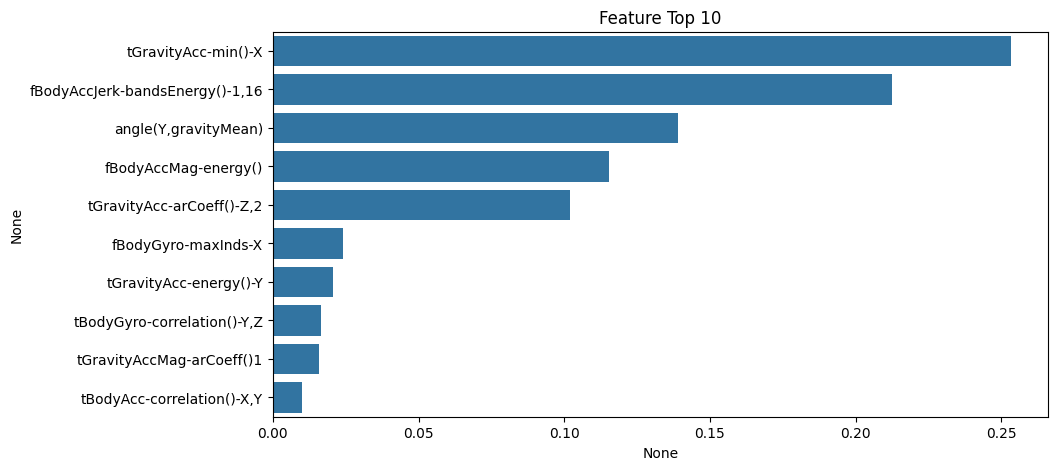

In [ ]:
feature_importance_values = best_dt_HAR.feature_importances_
# 최적 결정 트리 모델best_dt_HAR의 feature_importances_를 객체에 저장
# 가장 많은 영향을 끼치는 피처는 모든 피쳐의 중요도를 제공하는 API인 feature_importance_values임.
feature_importance_values_s = pd.Series(feature_importance_values, index = X_train.columns)
# 막대그래프로 그리기 위해 Series자료형으로 변환하여 저장

feature_top10 = feature_importance_values_s.sort_values(ascending = False)[:10]
# 중요도 값을 오름차순 정렬하여 상위 10개만 feature_top10에 저장 
# 중요 피처 10개를 막대 그래프로 나타냄

# 피쳐의 중요도(importance)가 숫자로 들어가 있음. 
# 이것과 컬럼의 이름 두개를 series로 엮어 결합시킴. 
# 그 후 가중치가 상위에서부터 뽑아서 top10을 뽑는다. (가중치는 상위에서부터 줄어듦)

plt.figure(figsize = (10, 5))
plt.title('Feature Top 10')
sns.barplot(x = feature_top10, y = feature_top10.index)
plt.show()

## 결과 시각화
### [결정트리모델의 트리구조를 그림으로 시각화]

In [51]:
from sklearn.tree import export_graphviz
export_graphviz(best_dt_HAR, out_file = "./data/tree.dot", class_names = label_name, 
                feature_names = feature_name, impurity = True, filled = True)
# 결정 트리 모델best_dt_HAR의 트리 구조 정보를 dot 파일로 생성

import graphviz
import os
os.environ['PATH'] += os.pathsep + r'C:\Program Files\Graphviz\bin' #운영체제 환경변수

In [ ]:
#위에서 생성된 tree.dot 파일을 Graphviz가 읽어서 시각화
with open("./data/tree.dot") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
graph.render(filename='graphviz_img',directory=".", format='png')
# dot 파일을 읽어서 트리 구조를 그림으로 나타냄

위에거 실행하면,, 에러가 뜬다.
```
ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings... 
```
path 설정 했는데도 해결이 안되네,,
암튼 환경 변수를 제대로 설정하면 정상적으로 트리가 시각화될 것임.